<a href="https://colab.research.google.com/github/xingchenzhao/study_deep_learning/blob/master/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install d2lzh  # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6

In [0]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn
import time

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2,strides=2),
        nn.Conv2D(channels=16,kernel_size=5,activation='sigmoid'),
        nn.MaxPool2D(pool_size=2,strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10)
        )

We build a 28*28 sample, and test and see the output shape of each layer

In [4]:
X = nd.random.uniform(shape=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 24, 24)
pool0 output shape:	 (1, 6, 12, 12)
conv1 output shape:	 (1, 16, 8, 8)
pool1 output shape:	 (1, 16, 4, 4)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


In [0]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Since the CNN is complex, we need to use GPU to accelerate the computation.

In [6]:
def try_gpu():
  try:
    ctx = mx.gpu()
    _ = nd.zeros((1,),ctx=ctx)
  except mx.base.MXNetError:
    ctx = mx.cpu()
  return ctx

ctx = try_gpu()
ctx

gpu(0)

We create a accuracy evalutation function

In [0]:
def evaluate_accuracy(data_iter, net, ctx):
  acc_sum, n = nd.array([0], ctx=ctx), 0
  for X, y in data_iter:
    X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
    acc_sum += (net(X).argmax(axis=1) == y).sum()
    n += y.size
  return acc_sum.asscalar() / n 

Define the training function

In [0]:
def train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs):
  print('Training on', ctx)
  loss = gloss.SoftmaxCrossEntropyLoss()
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    for X, y in train_iter:
      X, y = X.as_in_context(ctx), y.as_in_context(ctx)
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat,y).sum()
      l.backward()
      trainer.step(batch_size)
      y = y.astype('float32')
      train_l_sum += l.asscalar()
      train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
      n += y.size
    test_acc = evaluate_accuracy(test_iter,net,ctx)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start)) 

Training the LeNet

In [9]:
lr, num_epochs = 0.8, 120
net.initialize(force_reinit=True,ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': lr})
train_ch5(net,train_iter,test_iter,batch_size,trainer,ctx,num_epochs)

Training on gpu(0)
epoch 1, loss 2.3193, train acc 0.101, test acc 0.100, time 6.1 sec
epoch 2, loss 1.9579, train acc 0.245, test acc 0.602, time 6.0 sec
epoch 3, loss 0.9804, train acc 0.611, test acc 0.672, time 5.5 sec
epoch 4, loss 0.7718, train acc 0.700, test acc 0.729, time 5.7 sec
epoch 5, loss 0.6845, train acc 0.731, test acc 0.737, time 6.0 sec
epoch 6, loss 0.6348, train acc 0.748, test acc 0.766, time 5.8 sec
epoch 7, loss 0.5929, train acc 0.766, test acc 0.785, time 6.0 sec
epoch 8, loss 0.5501, train acc 0.784, test acc 0.801, time 5.7 sec
epoch 9, loss 0.5227, train acc 0.795, test acc 0.816, time 5.8 sec
epoch 10, loss 0.4916, train acc 0.812, test acc 0.817, time 6.0 sec
epoch 11, loss 0.4709, train acc 0.821, test acc 0.830, time 6.0 sec
epoch 12, loss 0.4559, train acc 0.826, test acc 0.840, time 5.9 sec
epoch 13, loss 0.4368, train acc 0.836, test acc 0.843, time 5.9 sec
epoch 14, loss 0.4213, train acc 0.842, test acc 0.854, time 5.6 sec
epoch 15, loss 0.4091, t

Prediction

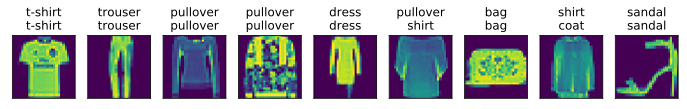

In [11]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X.as_in_context(ctx)).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])